In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import numba
import numpy as np

In [2]:
plt.rcParams['figure.dpi'] = 300

# Graphene

![lat](graphene_structure.png)

$$R = a_0 \begin{pmatrix} 1 \\ 0 \end{pmatrix}$$
$$a_1 = a_0 \begin{pmatrix} 3/2 \\ -\sqrt{3}/2 \end{pmatrix}$$
$$a_2 = a_0 \begin{pmatrix} 3/2 \\ \sqrt{3}/2 \end{pmatrix}$$
$$ r = n_1 a_1 + n_2 a_2 $$

$$ H = -t \sum_{r, \sigma} \left(
c_{r, \sigma}^\dagger c_{r+R, \sigma}
+ c_{r+a_1, \sigma}^\dagger c_{r+R, \sigma}
+ c_{r+a_2, \sigma}^\dagger c_{r+R, \sigma}
+ H.c.
\right) $$

$$ H = -t \sum_{r, \sigma}
\begin{pmatrix} c_{r, \sigma}^\dagger & c_{r+R, \sigma}^\dagger \end{pmatrix}
\begin{pmatrix} 0 & 1 \\ 1 & 0 \end{pmatrix}
\begin{pmatrix} c_{r, \sigma} \\ c_{r+R, \sigma} \end{pmatrix}
+ \begin{pmatrix} c_{r+a_1, \sigma}^\dagger & c_{r+R+a_1, \sigma}^\dagger \end{pmatrix}
\begin{pmatrix} 0 & 1 \\ 0 & 0 \end{pmatrix}
\begin{pmatrix} c_{r, \sigma} \\ c_{r+R, \sigma} \end{pmatrix}
+ \begin{pmatrix} c_{r, \sigma}^\dagger & c_{r+R, \sigma}^\dagger \end{pmatrix}
\begin{pmatrix} 0 & 0 \\ 1 & 0 \end{pmatrix}
\begin{pmatrix} c_{r+a_1, \sigma} \\ c_{r+R+a_1, \sigma} \end{pmatrix}
+ \begin{pmatrix} c_{r+a_2, \sigma}^\dagger & c_{r+R+a_2, \sigma}^\dagger \end{pmatrix}
\begin{pmatrix} 0 & 1 \\ 0 & 0 \end{pmatrix}
\begin{pmatrix} c_{r, \sigma} \\ c_{r+R, \sigma} \end{pmatrix}
+ \begin{pmatrix} c_{r, \sigma}^\dagger & c_{r+R, \sigma}^\dagger \end{pmatrix}
\begin{pmatrix} 0 & 0 \\ 1 & 0 \end{pmatrix}
\begin{pmatrix} c_{r+a_2, \sigma} \\ c_{r+R+a_2, \sigma} \end{pmatrix}
$$

In [3]:
tau_x = np.array([[0,1],[1,0]])
tau_p = np.array([[0,1],[0,0]])
tau_m = np.array([[0,0],[1,0]])

def hamiltonian(N, t=1):
    H = np.zeros((N, N, 2, N, N, 2))
    for n1, n2 in np.ndindex(N, N):
        H[n1,n2,:,n1,n2,:] = -t * tau_x
        H[(n1+1)%N,n2,:,n1,n2,:] = -t * tau_p
        H[n1,n2,:,(n1+1)%N,n2,:] = -t * tau_m
        H[n1,(n2+1)%N,:,n1,n2,:] = -t * tau_p
        H[n1,n2,:,n1,(n2+1)%N,:] = -t * tau_m
    return H.reshape(2*N**2, 2*N**2)

In [4]:
H = hamiltonian(64)

In [5]:
H.nbytes

536870912

In [6]:
(2*64**2)**2 * 8

536870912

In [7]:
(2*64**2)**2 * 8 / 1024**3

0.5

In [8]:
def calc_ldos(en, wf, omega, delta):
    omega = np.atleast_1d(omega)
    abs2wf = np.abs(wf)**2
    kernel = delta / np.pi / ((en[:,None] - omega[None,:])**2 + delta**2)
    return abs2wf.dot(kernel)

In [9]:
en, wf = np.linalg.eigh(H)

In [10]:
omega = np.linspace(-4, 4, 401)
ldos = calc_ldos(en, wf, omega, 0.05)
dos = ldos.mean(axis=0)

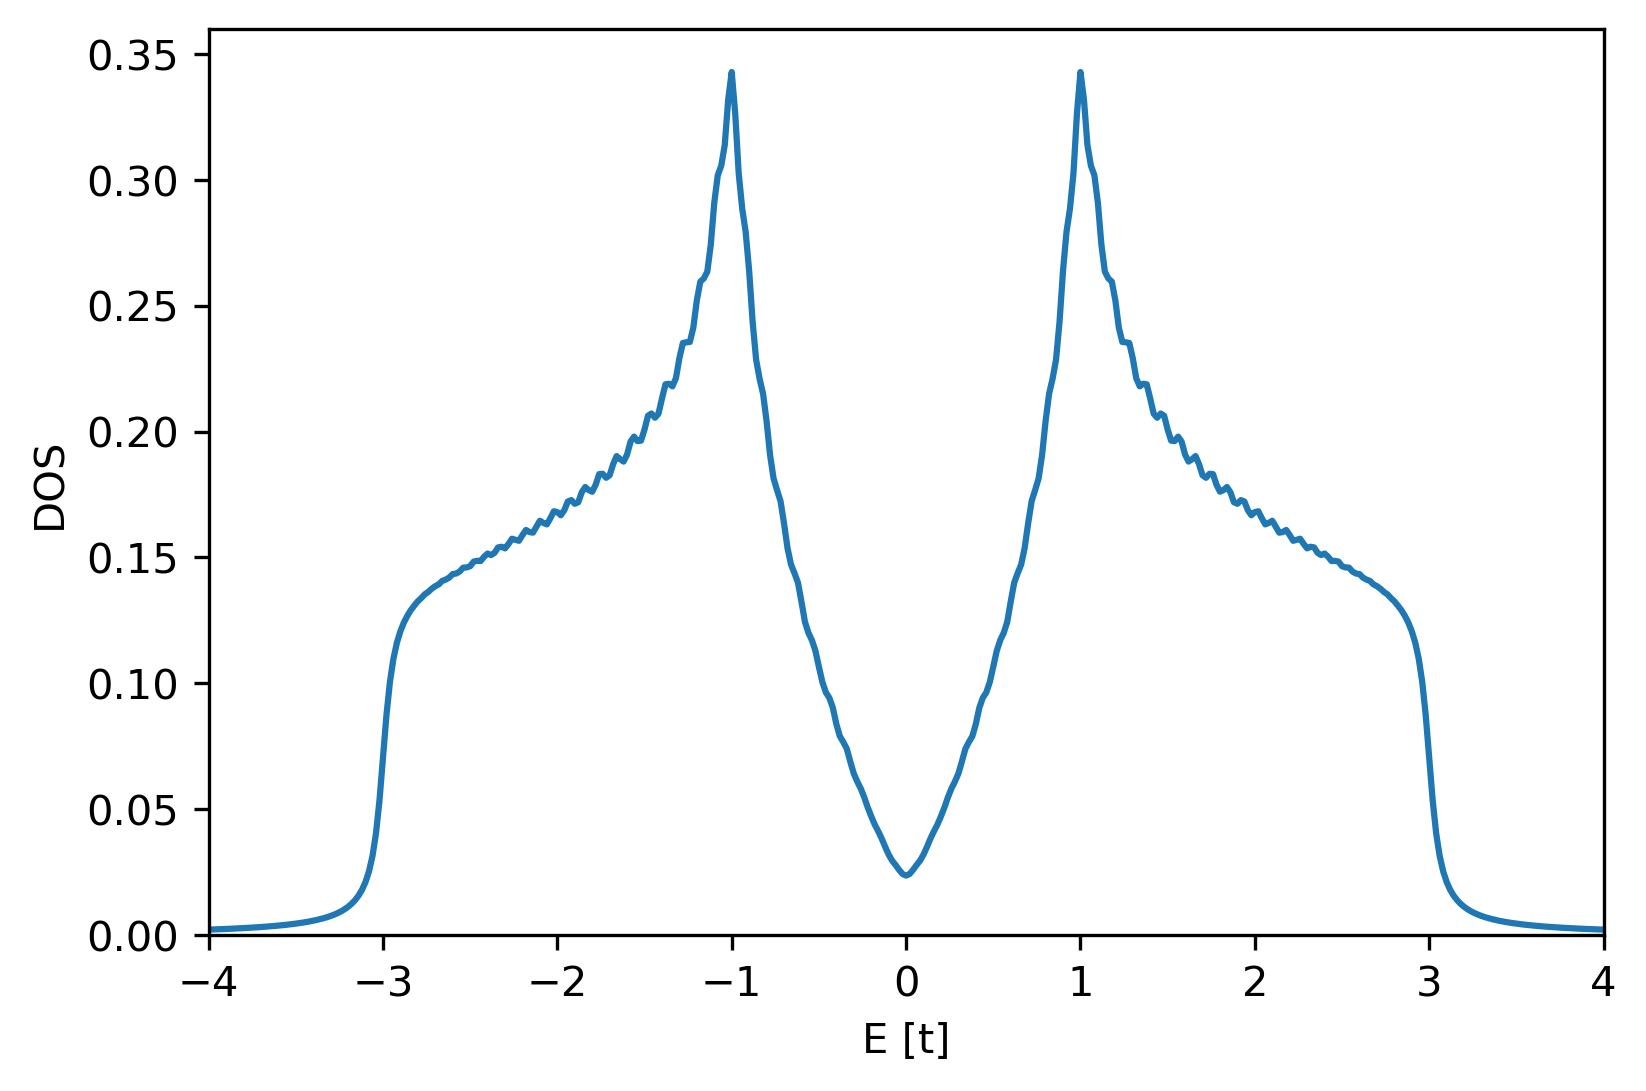

In [11]:
fig, ax = plt.subplots()
ax.plot(omega, dos)
ax.set_xlim(omega[0], omega[-1])
ax.set_ylim(0)
ax.set_xlabel('E [t]')
ax.set_ylabel('DOS')
plt.show()

# Kwant

In [12]:
import kwant

In [13]:
N = 64
t = 1
a1 = np.array([1.5, -3**0.5/2])
a2 = np.array([1.5, 3**0.5/2])

lat = kwant.lattice.general([a1, a2])
sys = kwant.Builder()
for n1, n2 in np.ndindex(N, N):
    sys[lat(n1, n2)] = -t * tau_x

for n1, n2 in np.ndindex(N, N):
    sys[lat(n1, n2), lat((n1+1)%N, n2)] = -t * tau_m
    sys[lat(n1, n2), lat(n1, (n2+1)%N)] = -t * tau_m

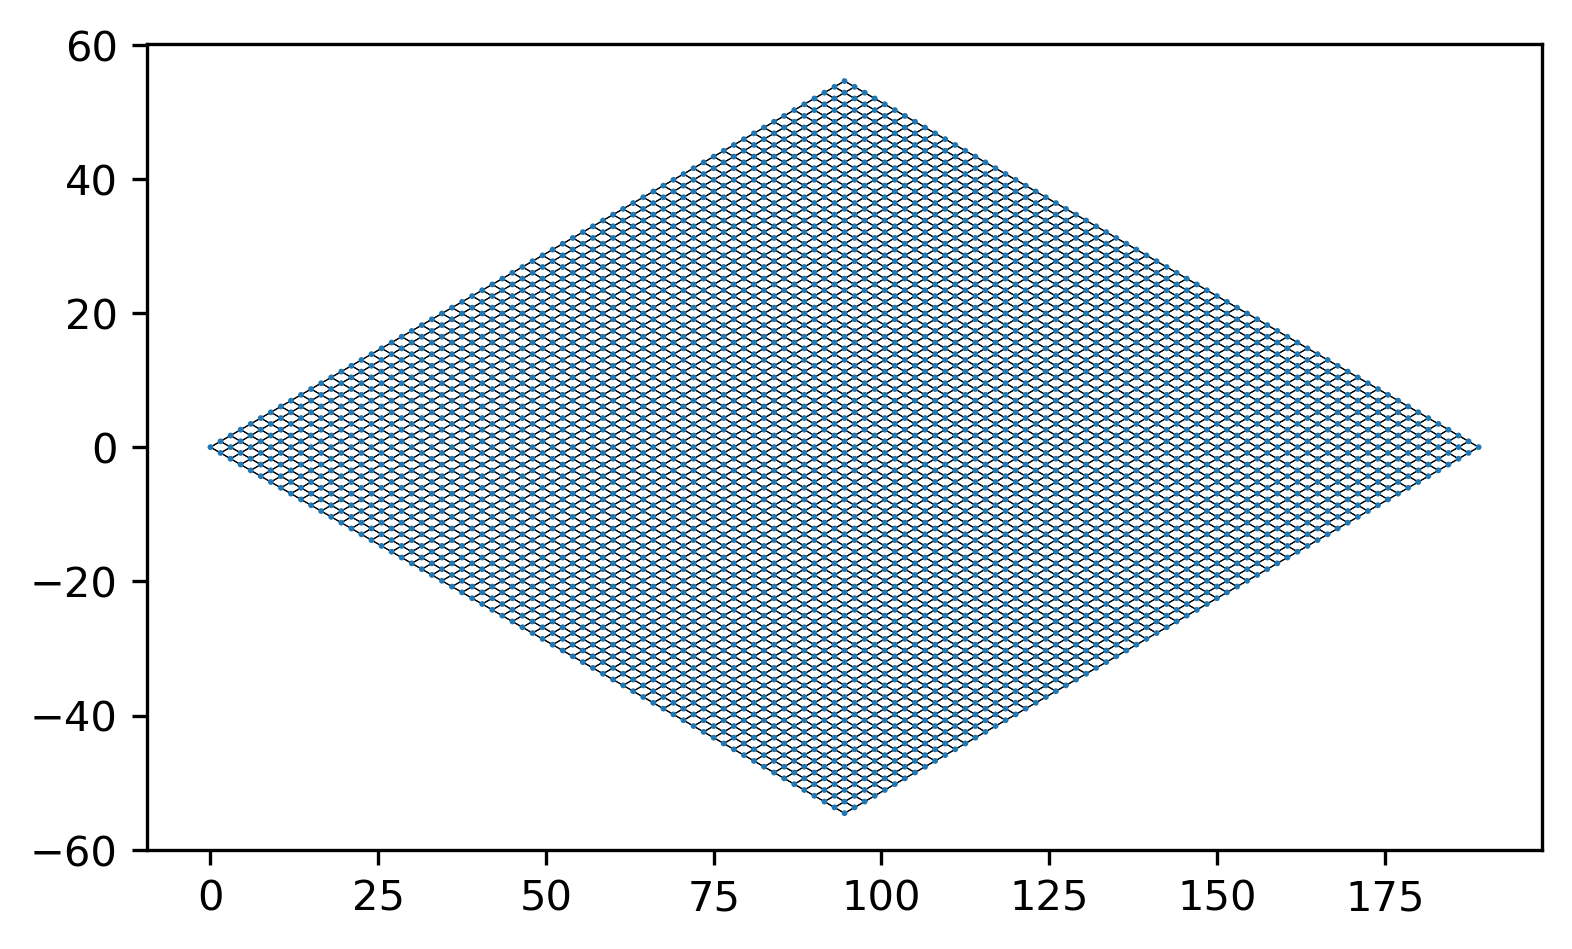

In [14]:
kwant.plot(sys);

In [15]:
sys = sys.finalized()
H = sys.hamiltonian_submatrix()

en, wf = np.linalg.eigh(H)

omega = np.linspace(-4, 4, 401)
ldos = calc_ldos(en, wf, omega, 0.05)
dos = ldos.mean(axis=0)

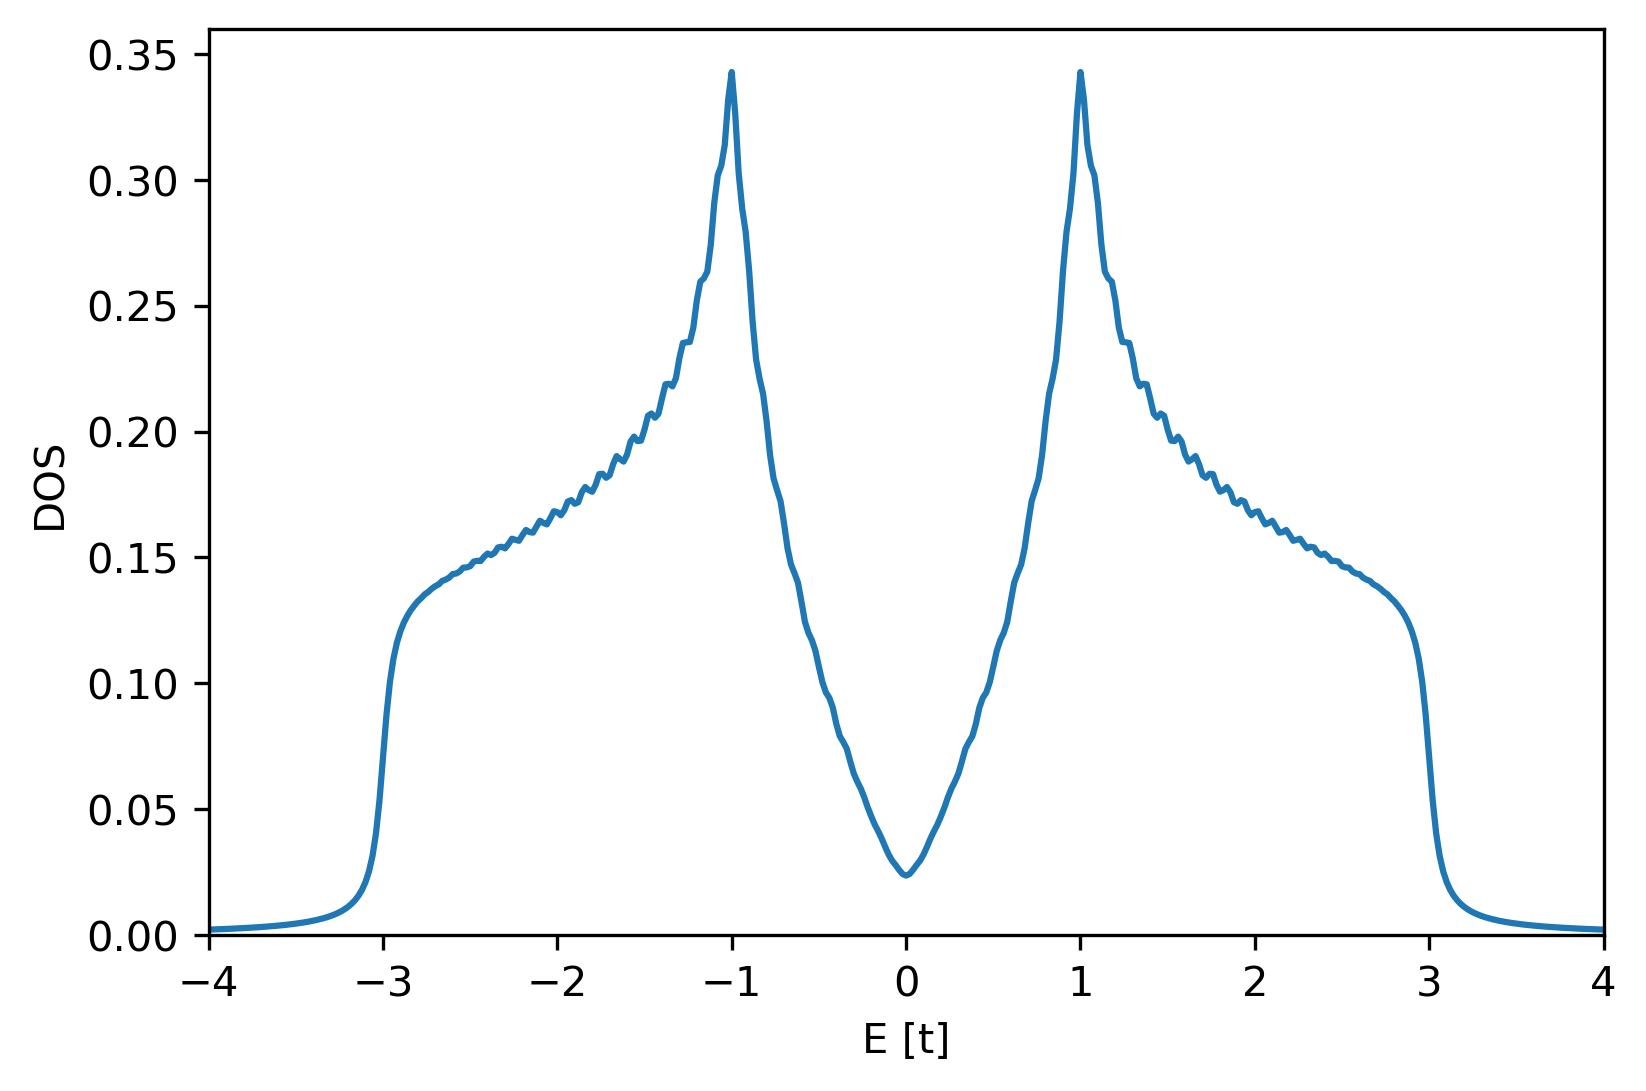

In [16]:
fig, ax = plt.subplots()
ax.plot(omega, dos)
ax.set_xlim(omega[0], omega[-1])
ax.set_ylim(0)
ax.set_xlabel('E [t]')
ax.set_ylabel('DOS')
plt.show()

# Fourier Transform

We construct the primitive reciprocal lattice vectors using
$$ a_i \cdot b_j = 2\pi \delta_{ij} $$

This can be represented using matrices
$$ \begin{pmatrix} a_1^T \\ a_2^T \end{pmatrix}
\begin{pmatrix} b_1 & b_2 \end{pmatrix}
= 2\pi \begin{pmatrix} 1 & 0 \\ 0 & 1 \end{pmatrix} $$

Therefore
$$ \begin{pmatrix} b_1 & b_2 \end{pmatrix}
= 2\pi \begin{pmatrix} a_1^T \\ a_2^T \end{pmatrix}^{-1} $$

In the case that $\begin{pmatrix} a_1^T \\ a_2^T \end{pmatrix}$ is not a square matrix, we can instead use
$$ \begin{pmatrix} a_1 & a_2 \end{pmatrix} \begin{pmatrix} a_1^T \\ a_2^T \end{pmatrix}
\begin{pmatrix} b_1 & b_2 \end{pmatrix}
= 2\pi \begin{pmatrix} a_1 & a_2 \end{pmatrix} $$

$$ \begin{pmatrix} b_1 & b_2 \end{pmatrix}
= 2\pi \left[ a_1 a_1^T + a_2 a_2^T \right]^{-1} \begin{pmatrix} a_1 & a_2 \end{pmatrix} $$

The possible momenta are
$$ k = m_1 b_1/N + m_2 b_2/N $$

$$ k \cdot r = \frac{2\pi}{N} (m_1 n_1 + m_2 n_2) $$

The discrete Fourier transform has the orthogonality relation
$$ \sum_{n=0}^{N-1} \exp \left( \frac{2\pi i}{N} (m-m') n \right) = N \delta_{mm'} $$

We define the Fourier transformed operators
$$ c_{r, \sigma} = \frac{1}{\sqrt{N_{tot}}} \sum_{k} c_{k, \sigma} e^{i k \cdot r} $$
$$ c_{k, \sigma} = \frac{1}{\sqrt{N_{tot}}} \sum_{k} c_{r, \sigma} e^{-i k \cdot r} $$

$$ H = -t \sum_{k, \sigma}
\begin{pmatrix} c_{k, \sigma}^\dagger & c_{k, \sigma}^\dagger e^{-i k R} \end{pmatrix}
\begin{pmatrix} 0 & 1 + e^{-i k a_1} + e^{-i k a_2} \\ 1 + e^{i k a_1} + e^{i k a_2} & 0 \end{pmatrix}
\begin{pmatrix} c_{k, \sigma} \\ e^{i k R} c_{k, \sigma} \end{pmatrix}
$$

$$ H = \sum_{k, \sigma}
\begin{pmatrix} a_{k, \sigma}^\dagger & b_{k, \sigma}^\dagger \end{pmatrix}
\begin{pmatrix} 0 & f_k \\ f_k^* & 0 \end{pmatrix}
\begin{pmatrix} a_{k, \sigma} \\ b_{k, \sigma} \end{pmatrix}
$$

$$ f_k = e^{i k R}  + e^{i k (R-a_1)} + e^{i k (R-a_2)} $$

$$ H = \sum_{k, \sigma, \pm} \pm E_k \gamma_{k, \sigma, \pm}^\dagger \gamma_{k, \sigma, \pm} $$
$$ E_k^{\pm} = |1 + e^{-i k a_1} + e^{-i k a_2}| = |f_k| $$

In [62]:
def dispersion(N, t=1):
    Ek = np.zeros((N, N, 2))
    for n1, n2 in np.ndindex(N, N):
        f = 1 + np.exp(-2j*np.pi*n1/N) + np.exp(-2j*np.pi*n2/N)
        Ek[n1,n2,0] = -t*np.abs(f)
        Ek[n1,n2,1] = t*np.abs(f)
    return Ek

In [18]:
Nk = 64
Ek = dispersion(Nk)

In [19]:
a1 = np.array([1.5, -3**0.5/2])
a2 = np.array([1.5, 3**0.5/2])
b1, b2 = 2*np.pi*np.linalg.inv([a1, a2]).T

n = np.arange(Nk) / Nk
kx = n[:,None] * b1[0] + n[None,:] * b2[0]
ky = n[:,None] * b1[1] + n[None,:] * b2[1]

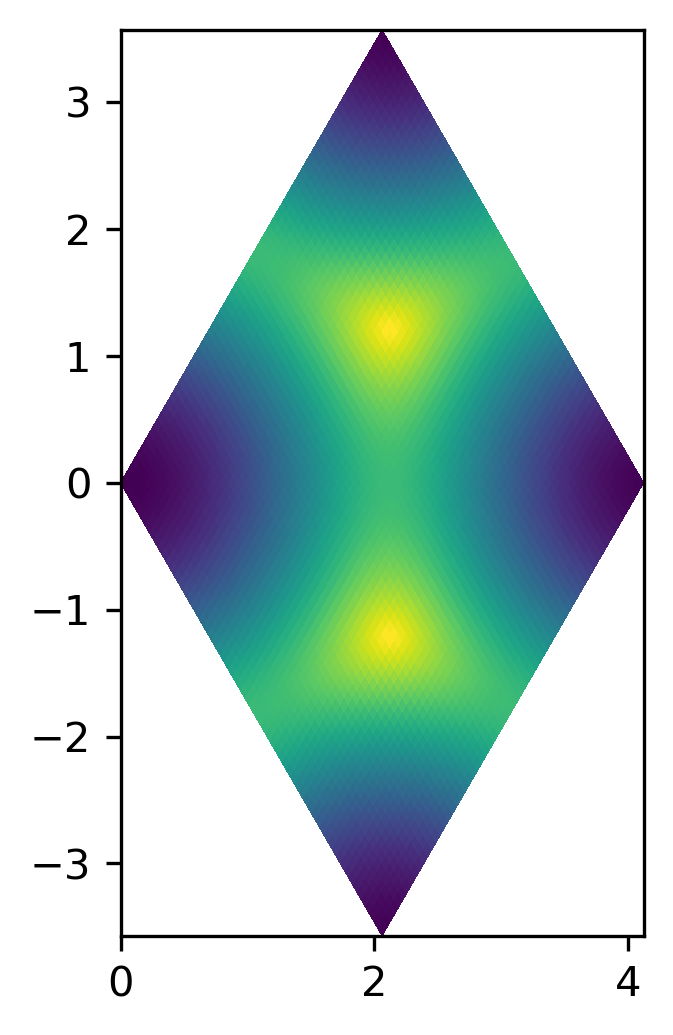

In [20]:
fig, ax = plt.subplots()
ax.pcolormesh(kx, ky, Ek[:,:,0])
ax.set_aspect(1)
plt.show()

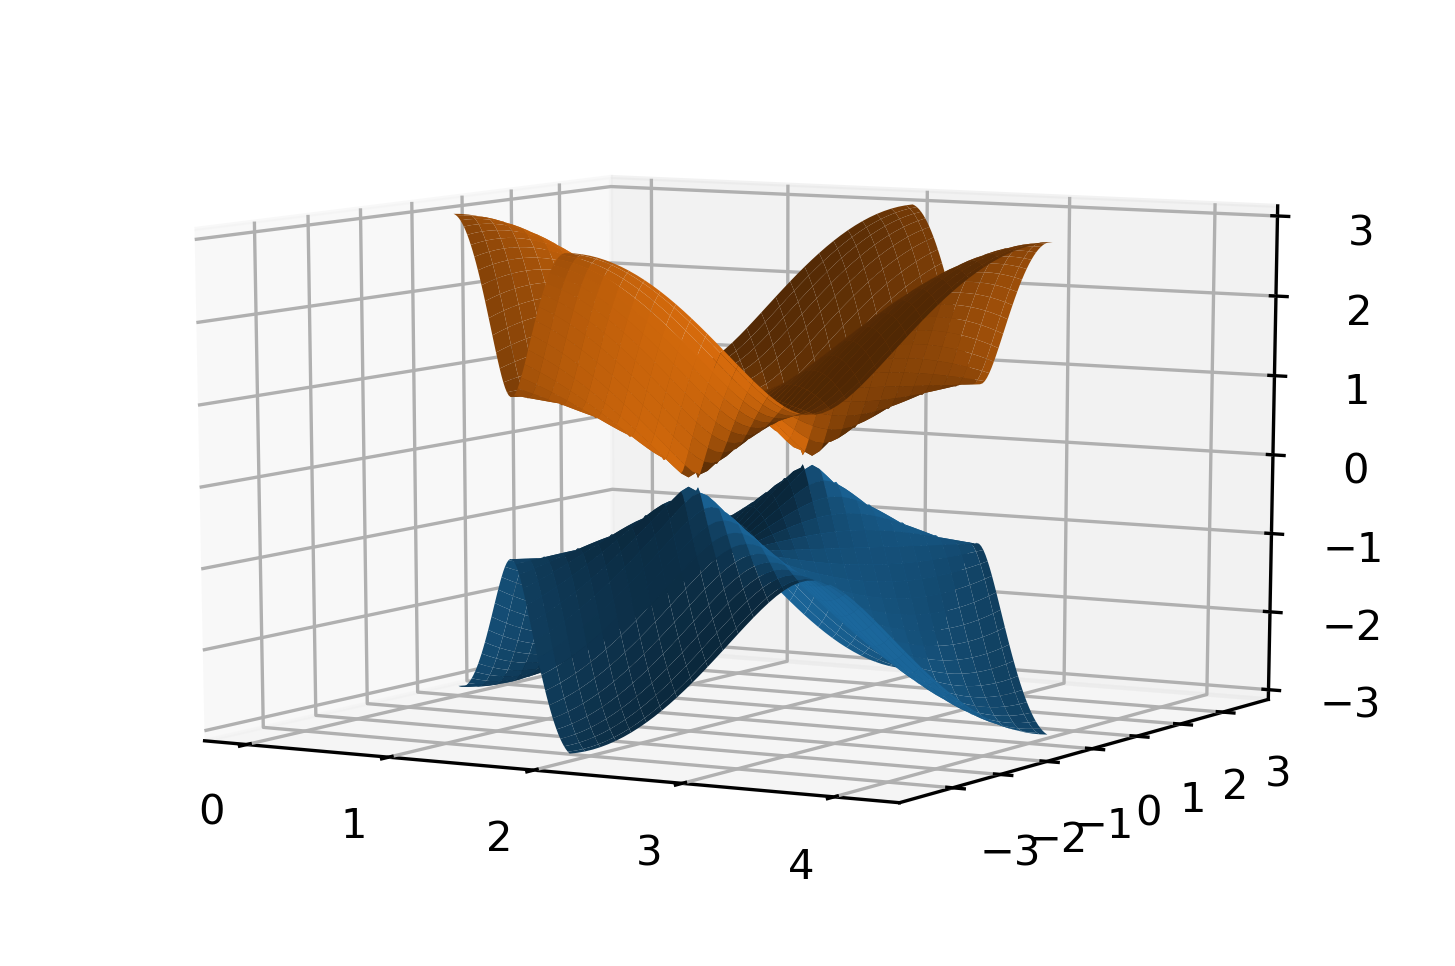

In [21]:
fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))
ax.plot_surface(kx, ky, Ek[:,:,0])
ax.plot_surface(kx, ky, Ek[:,:,1])
ax.view_init(elev=10)
plt.show()

In [22]:
def calc_dos(Ek, omega, delta):
    omega = np.atleast_1d(omega)
    return np.mean(delta / np.pi / ((Ek.ravel()[:,None] - omega[None,:])**2 + delta**2), axis=0)

In [23]:
omega = np.linspace(-4, 4, 401)
dos = calc_dos(Ek, omega, 0.05)

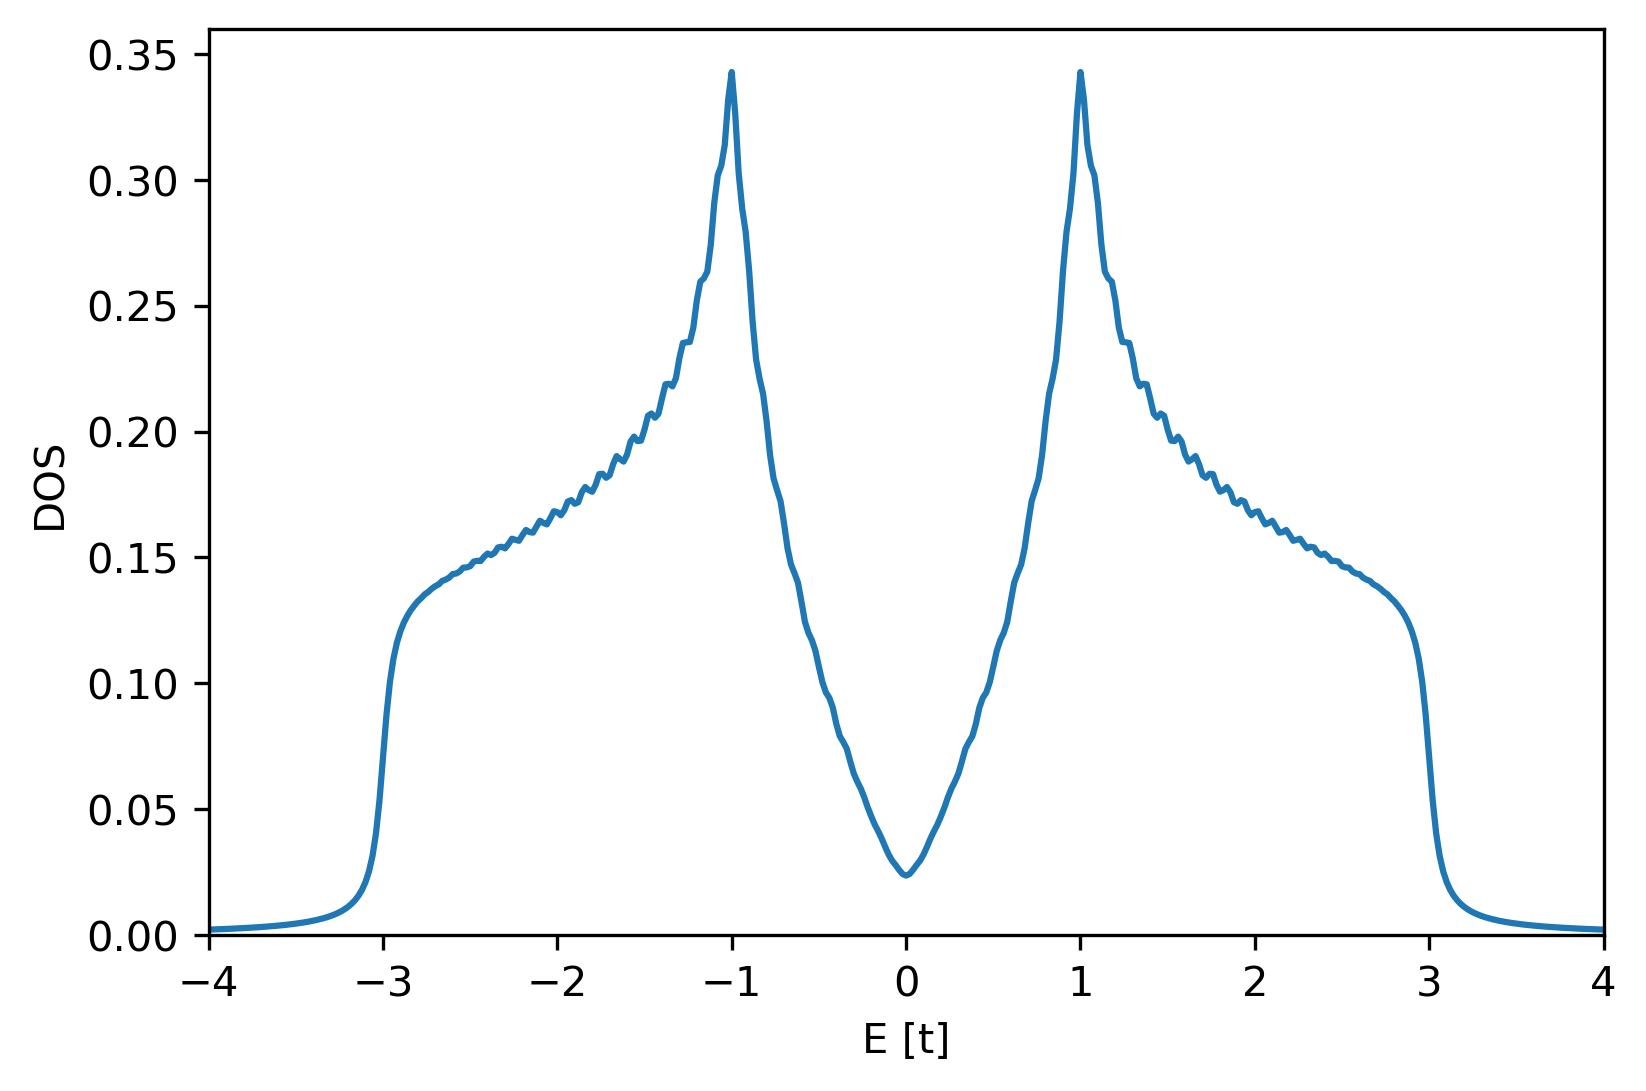

In [24]:
fig, ax = plt.subplots()
ax.plot(omega, dos)
ax.set_xlim(omega[0], omega[-1])
ax.set_ylim(0)
ax.set_xlabel('E [t]')
ax.set_ylabel('DOS')
plt.show()

In [25]:
Nk = 1024
Ek = dispersion(Nk)

In [26]:
omega = np.linspace(-4, 4, 401)
dos = calc_dos(Ek, omega, 0.005)

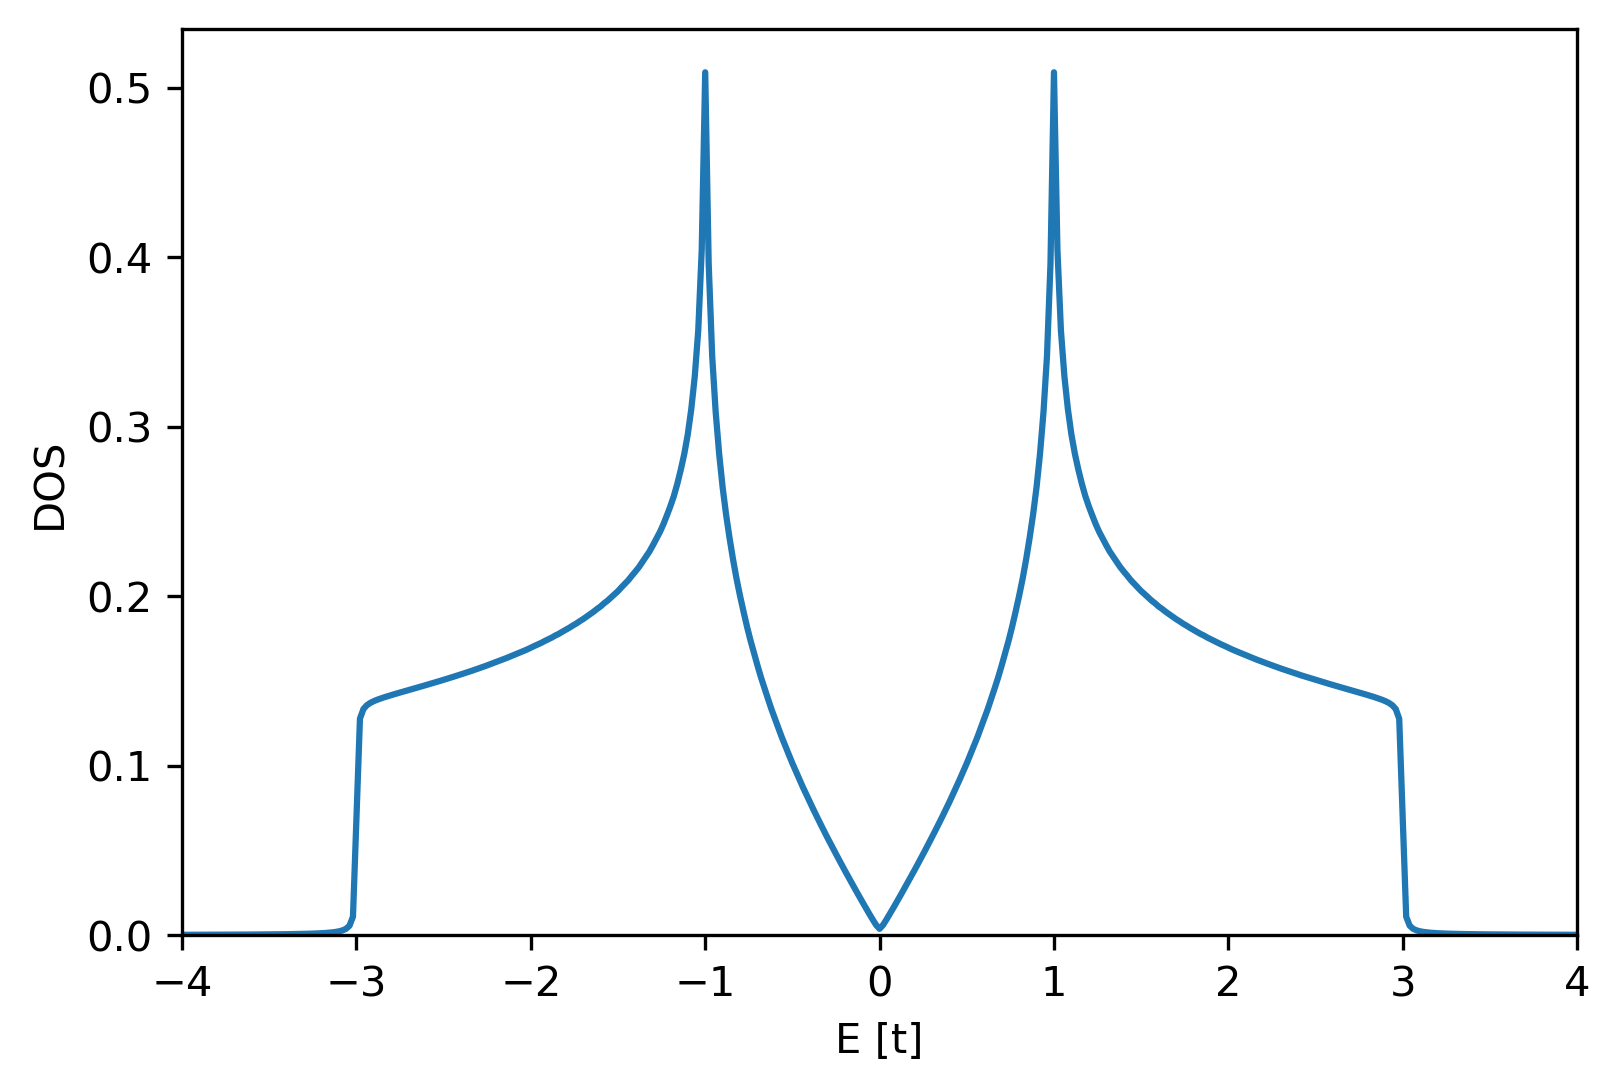

In [27]:
fig, ax = plt.subplots()
ax.plot(omega, dos)
ax.set_xlim(omega[0], omega[-1])
ax.set_ylim(0)
ax.set_xlabel('E [t]')
ax.set_ylabel('DOS')
plt.show()

# Bilayer Graphene

![lat](bilayer_structure.png)

For bilayer graphene, there are two layers of graphene, rotated 180 degrees around an A sublattice site.
Hoppings between AA, BB, and AB sublattices of different layers are $t_1$, $t_3$, and $t_4$, respectively.
Since A sublattices are directly overlapping, there is an additional potential $E_A$.

$$ H_k = \begin{pmatrix}
E_A & t_0 f_k & t_1 & t_4 f_k^* \\
t_0 f_k^* & 0 & t_4 f_k^* & t_3 f_k \\
t_1 & t_4 f_k & E_A & t_0 f_k^* \\
t_4 f_k & t_3 f_k^* & t_0 f_k & 0
\end{pmatrix} $$

The parameters are taken from
[From graphene to graphite: Electronic structure around the K point](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.74.075404)

In [28]:
# Lattice vectors
a = 1.42
a1 = a*np.array([1.5, -3**0.5/2])
a2 = a*np.array([1.5, 3**0.5/2])
b1, b2 = 2*np.pi*np.linalg.inv([a1, a2]).T

# High-symmetry points
G = np.array([0., 0.])
K = (b1 + 2*b2)/3
M = (b1 + b2)/2

# Hopping parameters
t0 = 3.12
t1 = 0.377
t2 = -0.0103
t3 = 0.29
t4 = -0.12
t5 = 0.0125
EA = 0.016+0.0206
EB = -0.0206+0.0206

In [29]:
@numba.njit
def bilayer_hamiltonian(k):
    """Calculate the Hamiltonian for bilayer graphene.

    Parameters
    ----------
    k : array(2)
        Momentum.

    Returns
    -------
    Hk : array(4,4)
        Hamiltonian.
    """
    e1 = np.exp(-1j * k.dot(a1))
    e2 = np.exp(-1j * k.dot(a2))
    e3 = np.exp(1j * k.dot(a1 + a2))
    f = 1 + e1 + e2
    g = np.conj(e1 + e2) + e3
    
    Hk = np.empty((4, 4), np.complex128)
    Hk[0,0] = EA
    Hk[0,1] = t0 * f
    Hk[0,2] = t1
    Hk[0,3] = t4 * f.conjugate()
    Hk[1,0] = t0 * f.conjugate()
    Hk[1,1] = EB
    Hk[1,2] = t4 * f.conjugate()
    Hk[1,3] = t3 * g
    Hk[2,0] = t1
    Hk[2,1] = t4 * f
    Hk[2,2] = EA
    Hk[2,3] = t0 * f.conjugate()
    Hk[3,0] = t4 * f
    Hk[3,1] = t3 * g.conjugate()
    Hk[3,2] = t0 * f
    Hk[3,3] = EB

    return Hk

In [30]:
Nk = 128
n = np.arange(Nk) / Nk
kx = n[:,None] * b1[0] + n[None,:] * b2[0]
ky = n[:,None] * b1[1] + n[None,:] * b2[1]
Ek = np.zeros((Nk, Nk, 4))
for n1, n2 in np.ndindex(Nk, Nk):
    k = np.array((kx[n1,n2], ky[n1,n2]))
    Ek[n1,n2] = np.linalg.eigvalsh(bilayer_hamiltonian(k))

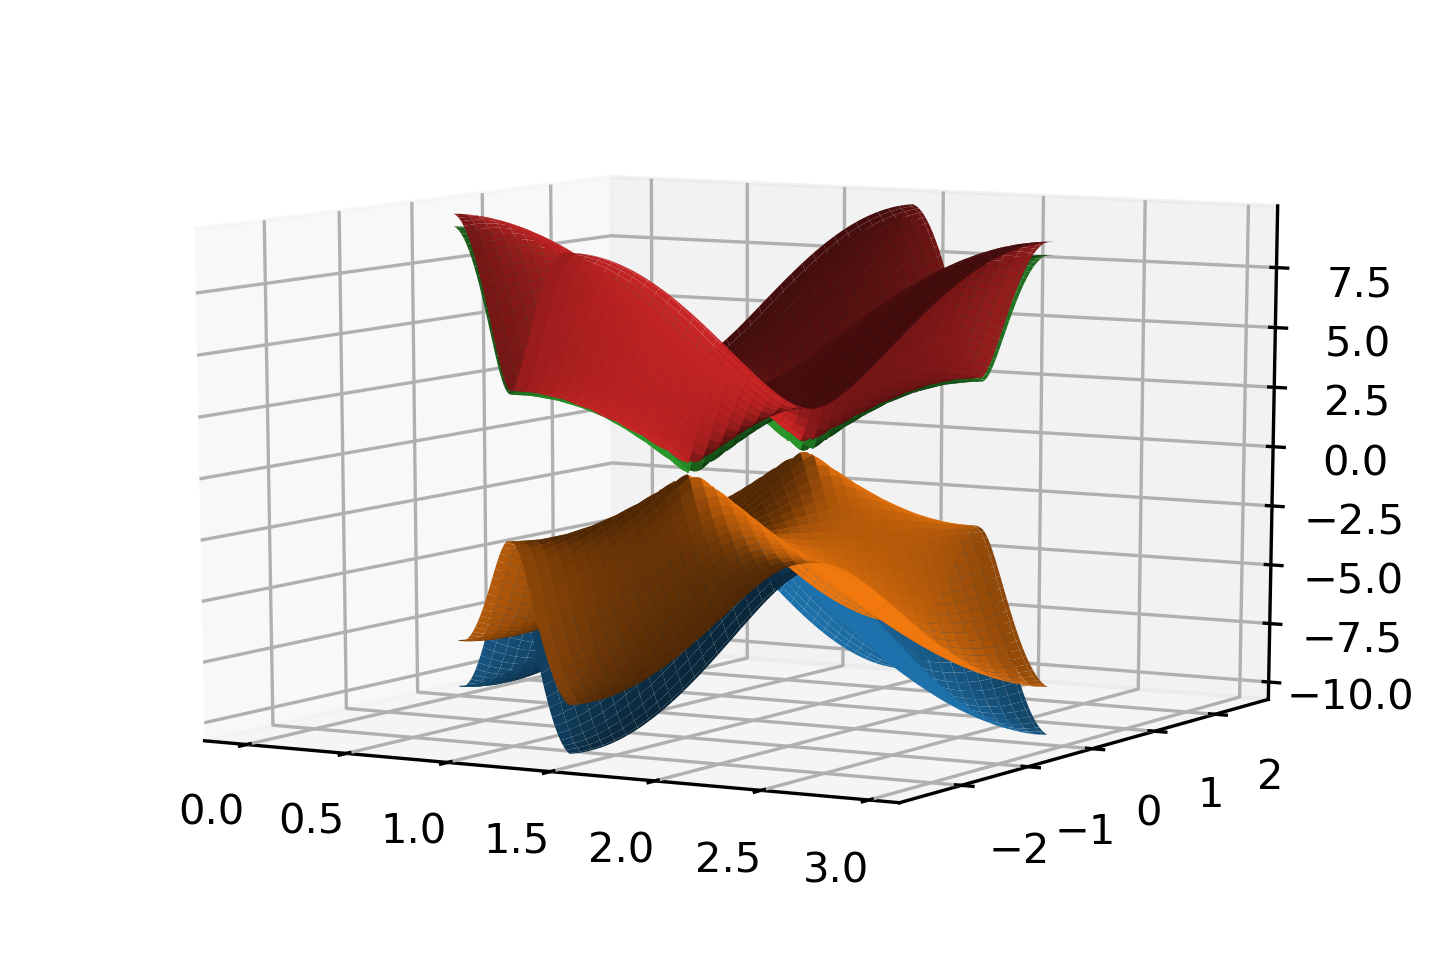

In [31]:
fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))
for n in range(4):
    ax.plot_surface(kx, ky, Ek[:,:,n])
ax.view_init(elev=10)
plt.show()

In [32]:
def make_kpath(points):
    """Make an interpolator on the domain [0, 1] to "points".
    
    Parameters
    ----------
    points : list
        List of k-points
    
    Returns
    ip : callable
        scipy.interpolate.interp1d object.
    dist : array
        Location of points on the domain [0, 1].
    """
    from scipy.interpolate import interp1d
    points = np.asarray(points)
    # Get total distance
    dist = np.array([0] + [np.linalg.norm(points[i] - points[i-1]) for i in range(1, len(points))])
    cum_dist = np.cumsum(dist)
    # Normalized distance
    dist = cum_dist / cum_dist[-1]
    ip = interp1d(dist, points, axis=0, kind=1)
    # Return interpolation and location of points
    return ip, dist

In [33]:
kpath, dist = make_kpath([G, M, K, G])
x = np.linspace(0, 1, 500)
ks = kpath(x)

Ek = np.zeros((x.size, 4))
for i in range(x.size):
    Ek[i] = np.linalg.eigvalsh(bilayer_hamiltonian(ks[i]))

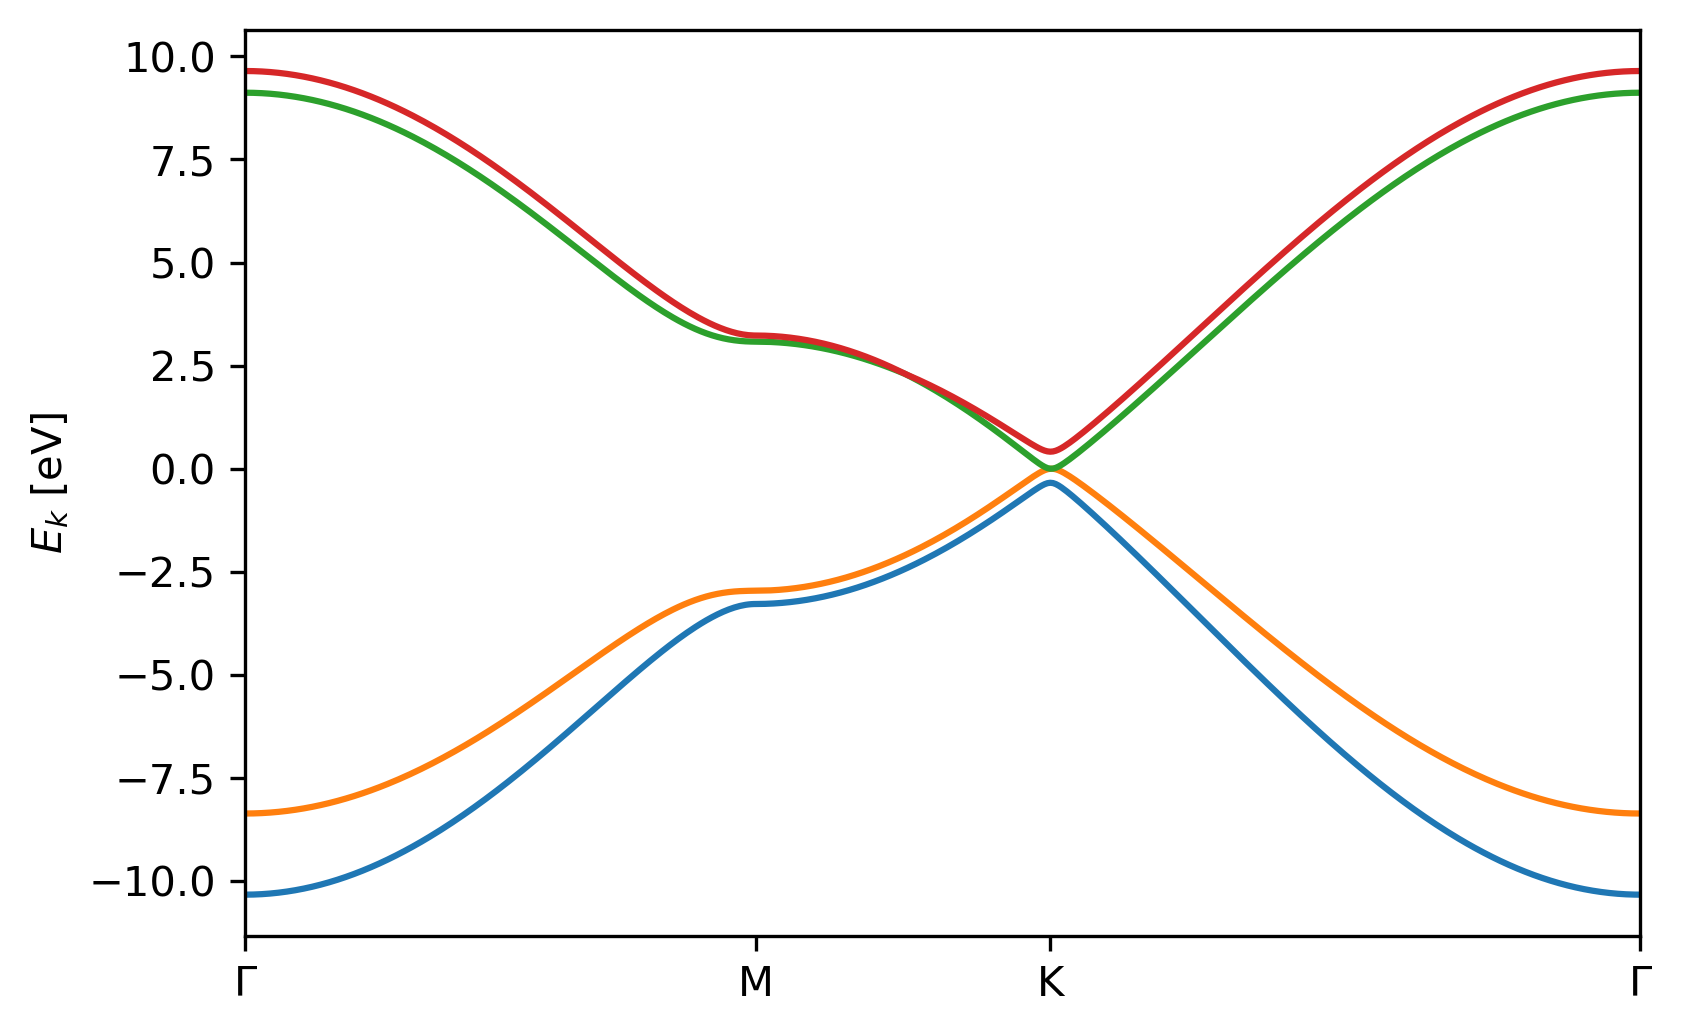

In [34]:
fig, ax = plt.subplots()
ax.plot(x, Ek)
ax.set_xlim(x[0], x[-1])
ax.set_xticks(dist)
ax.set_xticklabels([r'$\Gamma$', 'M', 'K', r'$\Gamma$'])
ax.set_ylabel(r'$E_k$ [eV]')
plt.show()

# Semi-infinite Graphite

Highly oriented pyrolytic graphite (HOPG) is a synthetic form of graphite where the layers stack in ABAB
The Hamiltonian has the form

$$ H_k = \begin{pmatrix}
h_k & t_k \\
t_k^\dagger & h_k & t_k \\
& t_k^\dagger & \ddots & \ddots \\
& & \ddots & \ddots
\end{pmatrix} $$

where $h_k$ is the Hamiltonian for bilayer graphene and $t_k$ is the interaction between neighboring bilayers.
This matrix is block tridiagonal and toeplitz (diagonals are the same).
Using a recursive algorithm, it is possible to get elements of the Green's functions.

[Highly convergent schemes for the calculation of bulk and surface Green functions](https://iopscience.iop.org/article/10.1088/0305-4608/15/4/009/meta).

In [35]:
@numba.njit
def hamiltonian_block(k):
    """Calculate the blocks of the Hamiltonian for a slab geometry.

    The Hamiltonian is in block Toeplitz form, i.e.
    H = [
        [ Hk,  Tk,  0,   0,  0],
        [Tk†,  Hk, Tk,   0,  0],
        [  0, Tk†, Hk,  Tk,  0],
        ...
        [  0,   0,  0, Tk†, Hk]
    ]

    Parameters
    ----------
    k : array(2)
        Momentum.

    Returns
    -------
    Hk : array(4,4)
        Diagonal block.
    Tk : array(4,4)
        Off-diagonal block.
    """
    e1 = np.exp(-1j * k.dot(a1))
    e2 = np.exp(-1j * k.dot(a2))
    e3 = np.exp(1j * k.dot(a1 + a2))
    f = 1 + e1 + e2
    g = np.conj(e1 + e2) + e3
    
    Hk = np.empty((4, 4), np.complex128)
    Hk[0,0] = EA
    Hk[0,1] = t0 * f
    Hk[0,2] = t1
    Hk[0,3] = t4 * f.conjugate()
    Hk[1,0] = t0 * f.conjugate()
    Hk[1,1] = EB
    Hk[1,2] = t4 * f.conjugate()
    Hk[1,3] = t3 * g
    Hk[2,0] = t1
    Hk[2,1] = t4 * f
    Hk[2,2] = EA
    Hk[2,3] = t0 * f.conjugate()
    Hk[3,0] = t4 * f
    Hk[3,1] = t3 * g.conjugate()
    Hk[3,2] = t0 * f
    Hk[3,3] = EB
    
    Tk = np.zeros((4, 4), np.complex128)
    Tk[0,0] = t5
    Tk[1,1] = t2
    Tk[2,0] = t1
    Tk[2,1] = t4 * f
    Tk[2,2] = t5
    Tk[3,0] = t4 * f
    Tk[3,1] = t3 * g.conjugate()
    Tk[3,3] = t2

    return Hk, Tk

In [36]:
@numba.njit
def greens_function(z, k, tol=1e-6, maxiter=20):
    """Calculate bulk and surface Green's functions.

    Parameters
    ----------
    z : complex
        Frequency.
        iω_n - Matsubara Green's function
        ω+iδ - Retarded Green's function
        ω-iδ - Advanced Green's function
    k : array(2)
        Momentum.
    tol : float
        Tolerance for convergence. Converges when effective hopping < tol. Default is 1e-6.
    maxiter : int
        Maximum number of iterations. Default is 20 (2^20 effective layers).

    Returns
    -------
    G : array(4, 4)
        Bulk Green's function.
    G_s : array(4, 4)
        Surface Green's function.
    """
    I = np.eye(4)
    eps, a = hamiltonian_block(k)
    eps_s = eps.copy()
    b = a.T.conj().copy()

    for n in range(maxiter):
        G = np.linalg.inv(z*I-eps)
        G_a = G.dot(a)
        G_b = G.dot(b)
        a_G_b = a.dot(G_b)

        # Update effective layer
        eps_s += a_G_b
        eps += a_G_b + b.dot(G_a)
        a = a.dot(G_a)
        b = b.dot(G_b)

        # Convergence test
        if np.abs(a).max() < tol and np.abs(b).max() < tol:
            break

    G = np.linalg.inv(z*I-eps)
    G_s = np.linalg.inv(z*I-eps_s)
    return G, G_s

In [37]:
a = 1.42
a1 = a*np.array([1.5, -3**0.5/2])
a2 = a*np.array([1.5, 3**0.5/2])
b1, b2 = 2*np.pi*np.linalg.inv([a1, a2]).T

@numba.njit(parallel=True)
def calc_semiinf_ldos(z, N, tol=1e-6, maxiter=20):
    n = np.arange(N) / N
    N_b = np.zeros(4)
    N_s = np.zeros(4)
    for n1 in numba.prange(N):
        for n2 in numba.prange(N):
            k = n[n1] * b1 + n[n2] * b2
            G_b, G_s = greens_function(z, k, tol, maxiter)
            N_b += -np.diag(G_b).imag / np.pi
            N_s += -np.diag(G_s).imag / np.pi
    return N_b / N**2, N_s / N**2

In [40]:
from progress import pindex

In [41]:
omega = np.linspace(-12, 12, 401)
N_b, N_s = np.zeros((2, omega.size, 4))
for i in pindex(omega.size):
    N_b[i], N_s[i] = calc_semiinf_ldos(omega[i]+0.005j, 1024)

IntProgress(value=0, max=401)

HTML(value='\n            <table>\n                <tr>\n                    <th>Progress:</th>\n             …

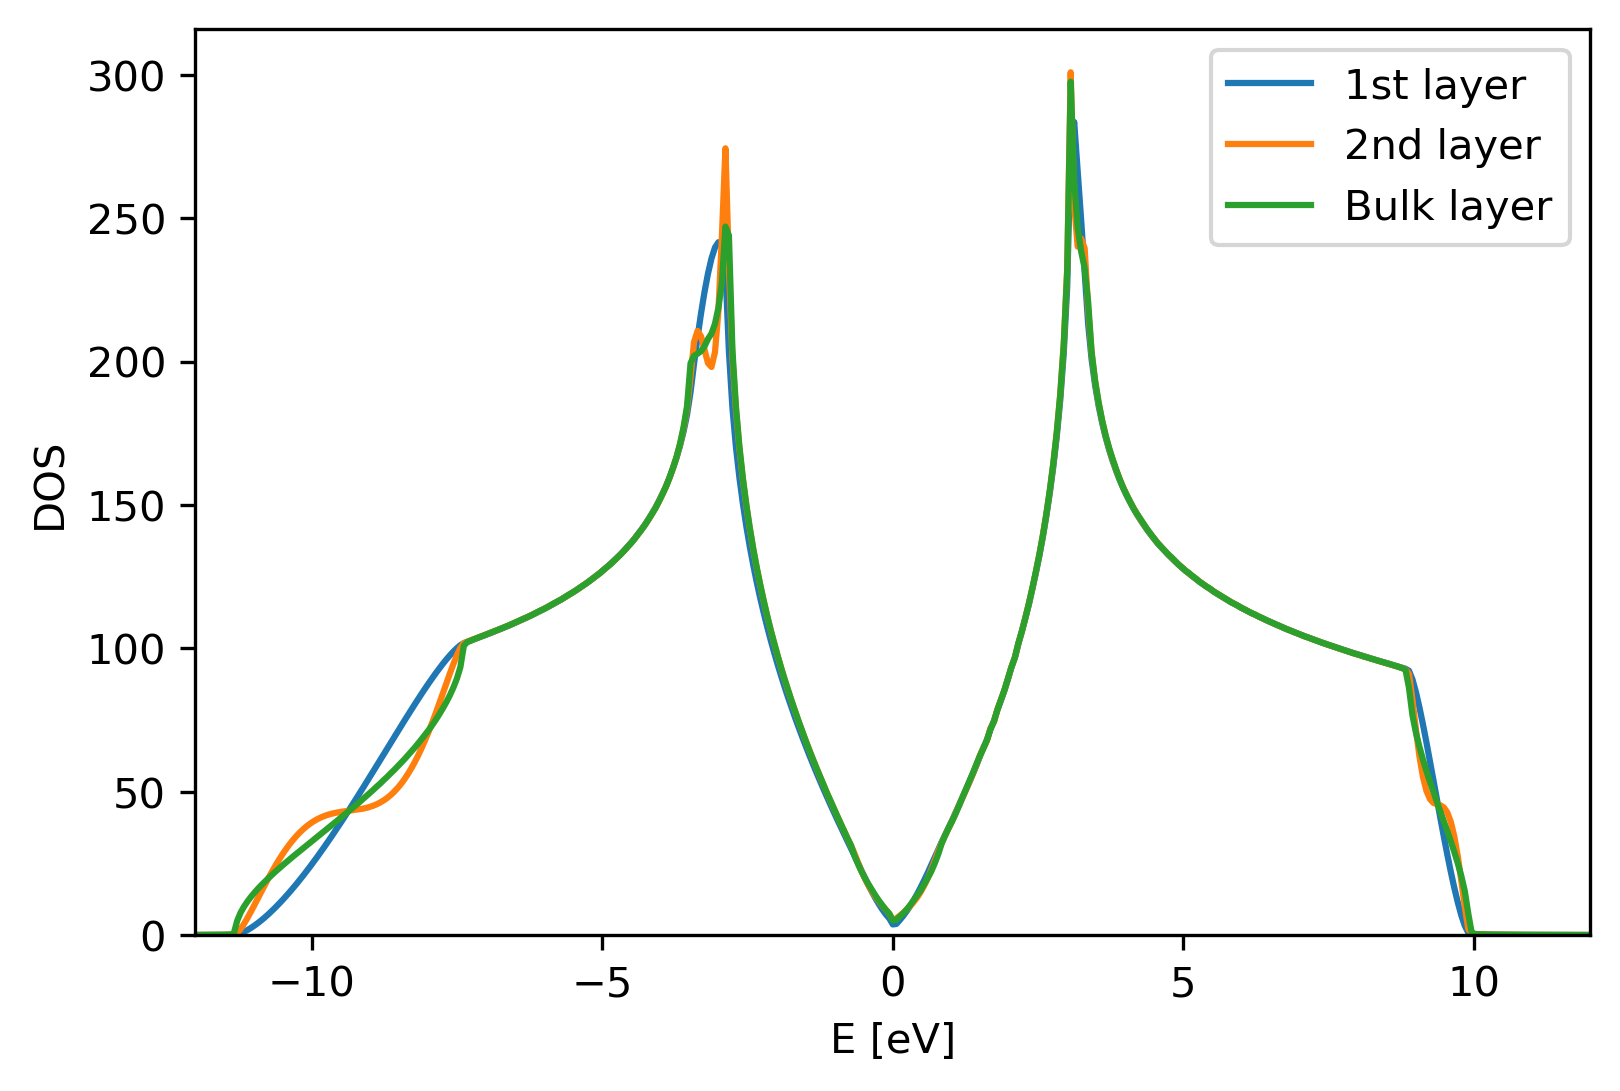

In [46]:
fig, ax = plt.subplots()
ax.plot(omega, N_s[:,0]+N_s[:,1], label='1st layer')
ax.plot(omega, N_s[:,2]+N_s[:,3], label='2nd layer')
ax.plot(omega, N_b[:,0]+N_b[:,1], label='Bulk layer')
ax.legend()
ax.set_xlim(omega[0], omega[-1])
ax.set_ylim(0)
ax.set_xlabel('E [eV]')
ax.set_ylabel('DOS')
plt.show()

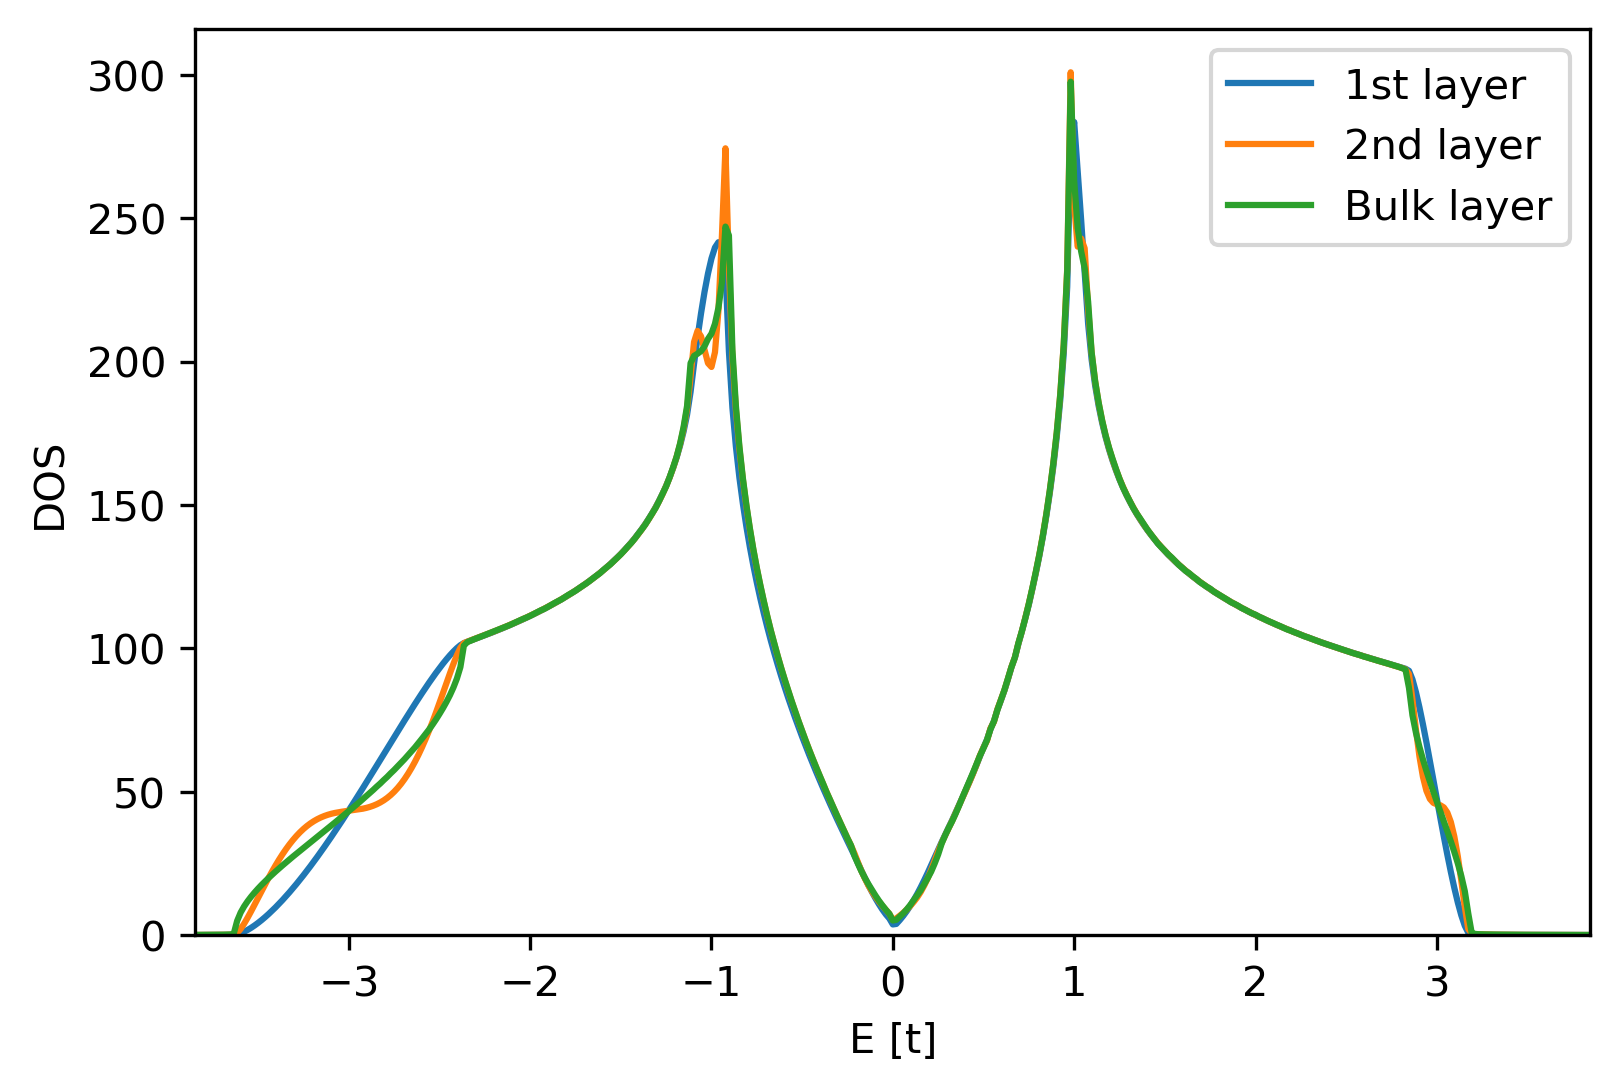

In [45]:
fig, ax = plt.subplots()
ax.plot(omega/t0, N_s[:,0]+N_s[:,1], label='1st layer')
ax.plot(omega/t0, N_s[:,2]+N_s[:,3], label='2nd layer')
ax.plot(omega/t0, N_b[:,0]+N_b[:,1], label='Bulk layer')
ax.legend()
ax.set_xlim(omega[0]/t0, omega[-1]/t0)
ax.set_ylim(0)
ax.set_xlabel('E [t]')
ax.set_ylabel('DOS')
plt.show()

In [63]:
Nk = 1024
Ek = dispersion(Nk, t=t0)
dos = calc_dos(Ek, omega, 0.005)

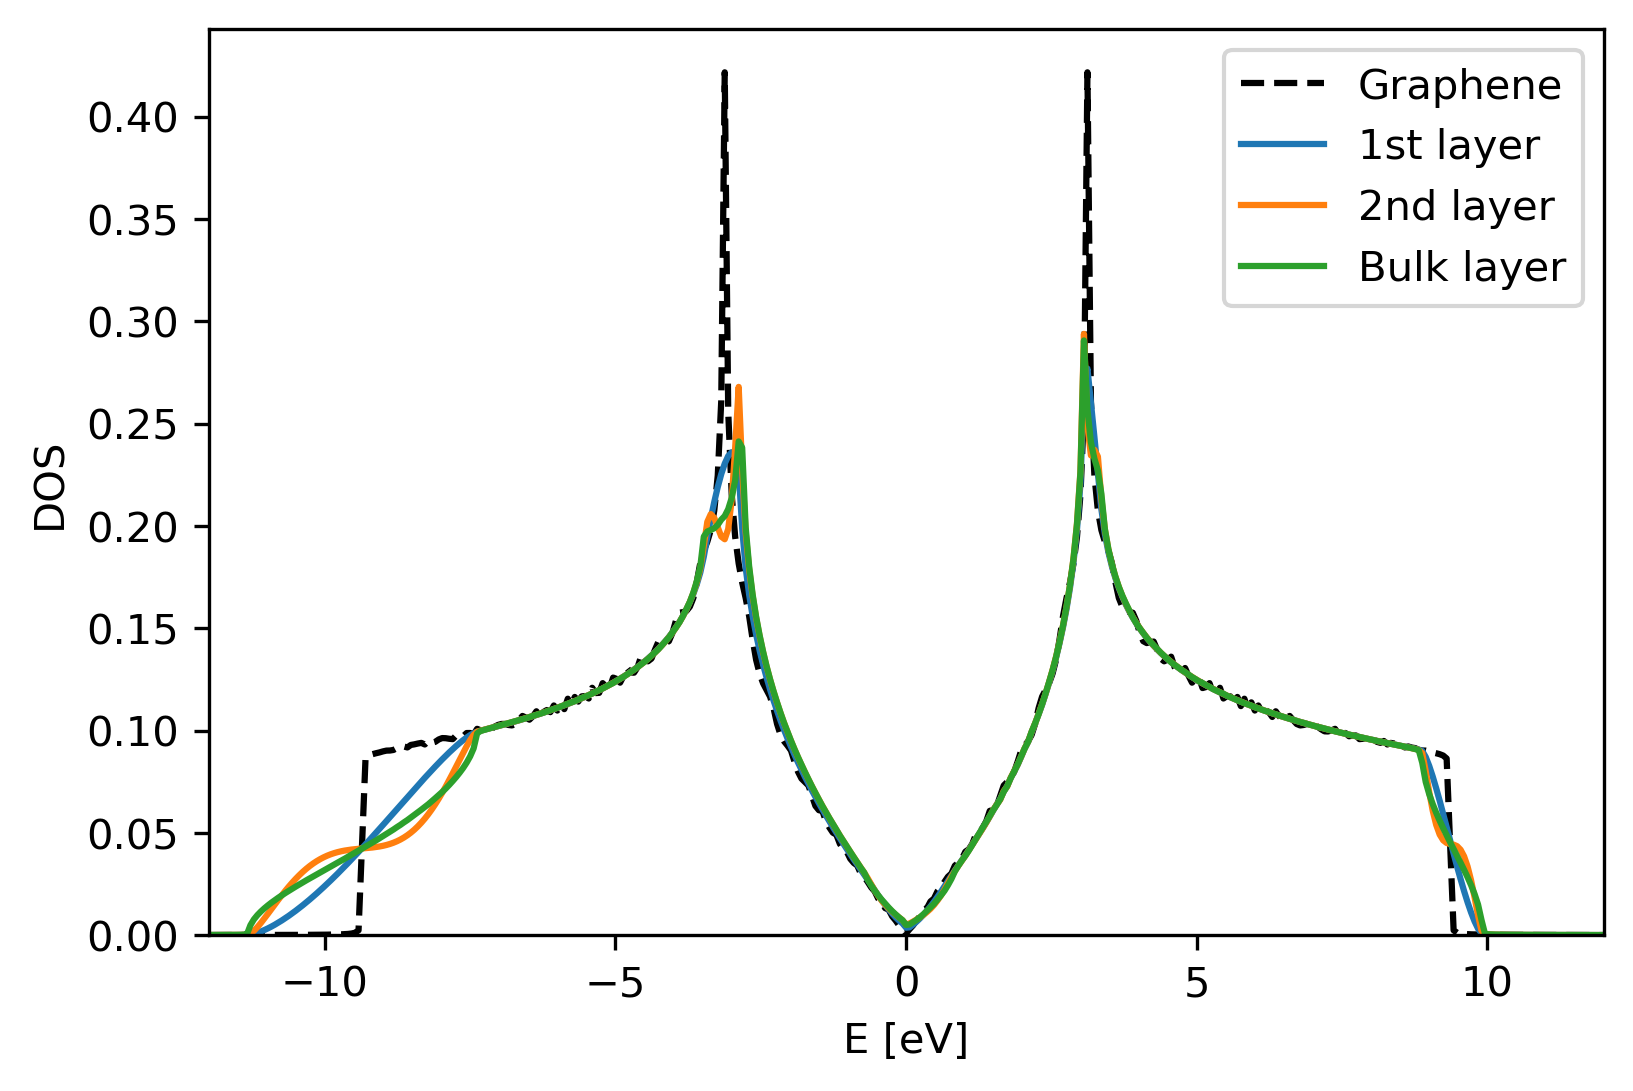

In [70]:
fig, ax = plt.subplots()
ax.plot(omega, 2*dos, 'k--', label='Graphene')
ax.plot(omega, N_s[:,0]+N_s[:,1], label='1st layer')
ax.plot(omega, N_s[:,2]+N_s[:,3], label='2nd layer')
ax.plot(omega, N_b[:,0]+N_b[:,1], label='Bulk layer')
ax.legend()
ax.set_xlim(omega[0], omega[-1])
ax.set_ylim(0)
ax.set_xlabel('E [eV]')
ax.set_ylabel('DOS')
plt.show()